In [1]:
import pyam
import pandas as pd
import os
import dotenv
import sys
import matplotlib.pyplot as plt
import numpy as np

sys.path.append('../scripts')
from utils import Validation, Filters

from pathlib import Path
%load_ext autoreload
%autoreload 2

c:\Users\gidden\Miniconda3\envs\pyam\Lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
fulldf = pd.read_csv(os.environ['AR6_RAW'])

In [3]:
voi = [
    'Carbon Sequestration|CCS',
    'Primary Energy|Fossil|w/ CCS',
    'Carbon Sequestration|CCS|Fossil',
    'Primary Energy|Fossil',
    'Primary Energy|Biomass',
    'Primary Energy|Non-Biomass Renewables',
    'Final Energy|Hydrogen',
    'Secondary Energy|Hydrogen|Non-Biomass Renewables',
    'Secondary Energy|Hydrogen|Renewables (incl. Biomass)',
]

pddf = fulldf[fulldf.Variable.isin(voi)]

df = pyam.IamDataFrame(pddf)
df.load_meta(os.environ['AR6_META'])
df = df.filter(Category=['failed-vetting', 'no-climate-assessment'], keep=False)

c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\utils.py:318: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=True)
[WARNING] 14:51:16 - pyam.core: Ignoring meta indicators for the following scenarios:
         model                       scenario
0  AIM/CGE 2.2   ADVANCE_WP2_IND-450-FullTech
1  AIM/CGE 2.2  ADVANCE_WP2_IND-Base-FullTech
2  AIM/CGE 2.2   ADVANCE_WP2_TRA-450-FullTech
3  AIM/CGE 2.2  ADVANCE_WP2_TRA-Base-FullTech
4  AIM/CGE 2.2  ADVANCE_WP2_TRA-Ctax-FullTech
...
         model                       scenario
0  AIM/CGE 2.2   ADVANCE_WP2_IND-450-FullTech
1  AIM/CGE 2.2  ADVANCE_WP2_IND-Base-FullTech
2  AIM/CGE 2.2   ADVANCE_WP2_TRA-450-FullTech
3  AIM/CGE 2.2  ADVANCE_WP2_TRA-Base-FullTech
4  AIM/CGE 2.2  ADVANCE_WP2_TRA-Ctax-FullTech
...


In [4]:
df.meta['Year of netzero GHG emissions (Harm-Infilled) Table SPM2'].unique()

array([  inf, 2051., 2086., 2065., 2069., 2072., 2075., 2078., 2080.,
       2083., 2089., 2077., 2076., 2081., 2082., 2085., 2088., 2090.,
       2098., 2070., 2079., 2097., 2074., 2055., 2073., 2092., 2099.,
       2093., 2071., 2068., 2084., 2063., 2087., 2067., 2066., 2061.,
       2050., 2064., 2096., 2056., 2060., 2094., 2091., 2058., 2059.,
       2062., 2100., 2057., 2053., 2052., 2054., 2095.])

In [5]:
for nz_t in ['Year of netzero CO2 emissions (Harm-Infilled) Table SPM2', 'Year of netzero GHG emissions (Harm-Infilled) Table SPM2']:
    df.meta[nz_t] = df.meta[nz_t].replace([np.inf, -np.inf], np.nan).fillna(2101).astype(int)
nz_co2 = df.meta['Year of netzero CO2 emissions (Harm-Infilled) Table SPM2']
nz_ghg = df.meta['Year of netzero GHG emissions (Harm-Infilled) Table SPM2']

In [6]:
def set_meta_at_nz(df, nz, name, **kwargs):
    idx = pd.MultiIndex.from_frame(nz.rename('year').to_frame().reset_index())
    data = df.filter(**kwargs).interpolate(range(2020, 2101))._data.droplevel(['region', 'variable', 'unit'])
    df.set_meta(meta=data.loc[idx.intersection(data.index)].droplevel('year'), name=name)



In [7]:
def values_until_net_zero(row, nz):
    row[row.index >= nz.loc[row.name[0], row.name[1]]] = 0
    return row

def make_cumulative_df(df, vold, vnew, offset=True, nz=None):
    data = df.filter(variable=vold).interpolate(range(2020, 2101))
    if offset:
        data = data.offset(year=2020)
    pddata = (
        data
        .filter(year=range(2020, 2101))
        .rename(variable={vold: vnew})
        .timeseries()
    )
    if nz is not None:
        pddata = pddata.apply(values_until_net_zero, args=(nz,), axis=1)
    ret = pyam.IamDataFrame(pddata.cumsum(axis=1))
    ret.set_meta(data.meta)
    return ret

<Axes: >

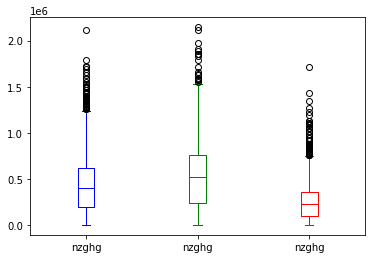

In [8]:
datanzco2 = make_cumulative_df(df, vold='Carbon Sequestration|CCS', vnew='Cumulative CCS until NZ CO2', offset=True, nz=nz_co2)
datanzghg = make_cumulative_df(df, vold='Carbon Sequestration|CCS', vnew='Cumulative CCS until NZ GHG', offset=True, nz=nz_ghg)
datafull = make_cumulative_df(df, vold='Carbon Sequestration|CCS', vnew='Cumulative CCS', offset=True)
fig, ax = plt.subplots()
datanzco2.filter(year=2100).timeseries().rename(columns={2100: 'nzco2'}).plot.box(ax=ax, color='r', positions=[1])
datafull.filter(year=2100).timeseries().rename(columns={2100: 'full'}).plot.box(ax=ax, color='g', positions=[0])
datanzghg.filter(year=2100).timeseries().rename(columns={2100: 'nzghg'}).plot.box(ax=ax, color='b', positions=[-1])

In [9]:
cumulative_vars = [
    dict(vold='Carbon Sequestration|CCS', vnew='Cumulative CCS', offset=True),
    dict(vold='Carbon Sequestration|CCS', vnew='Cumulative CCS until NZ CO2', offset=True, nz=nz_co2),
    dict(vold='Carbon Sequestration|CCS', vnew='Cumulative CCS until NZ GHG', offset=True, nz=nz_ghg),
    dict(vold='Carbon Sequestration|CCS|Fossil', vnew='Cumulative Fossil CCS', offset=True),
    dict(vold='Carbon Sequestration|CCS|Fossil', vnew='Cumulative Fossil CCS until NZ CO2', offset=True, nz=nz_co2),
    dict(vold='Carbon Sequestration|CCS|Fossil', vnew='Cumulative Fossil CCS until NZ GHG', offset=True, nz=nz_ghg),
    dict(vold='Primary Energy|Fossil', vnew='Cumulative Fossil PE', offset=False),
    dict(vold='Primary Energy|Fossil', vnew='Cumulative Fossil PE until NZ CO2', offset=False, nz=nz_co2),
    dict(vold='Primary Energy|Fossil', vnew='Cumulative Fossil PE until NZ GHG', offset=False, nz=nz_ghg),
    dict(vold='Primary Energy|Biomass', vnew='Cumulative Biomass PE', offset=False),
    dict(vold='Primary Energy|Biomass', vnew='Cumulative Biomass PE until NZ CO2', offset=False, nz=nz_co2),
    dict(vold='Primary Energy|Biomass', vnew='Cumulative Biomass PE until NZ GHG', offset=False, nz=nz_ghg),
    dict(vold='Primary Energy|Non-Biomass Renewables', vnew='Cumulative Renewables PE', offset=False),
    dict(vold='Primary Energy|Non-Biomass Renewables', vnew='Cumulative Renewables PE until NZ CO2', offset=False, nz=nz_co2),
    dict(vold='Primary Energy|Non-Biomass Renewables', vnew='Cumulative Renewables PE until NZ GHG', offset=False, nz=nz_ghg),
]
cum_data = pyam.concat([
    make_cumulative_df(df, **kwargs) for kwargs in cumulative_vars
    ])
pdf = pyam.concat([df, cum_data])
for d in cumulative_vars:
    pdf.set_meta_from_data(f"{d['vnew']} in 2100", **{'variable': d['vnew'], 'region': 'World', 'year': 2100})

Text(0.5, 1.0, 'Cumulative Carbon Stored via CCS')

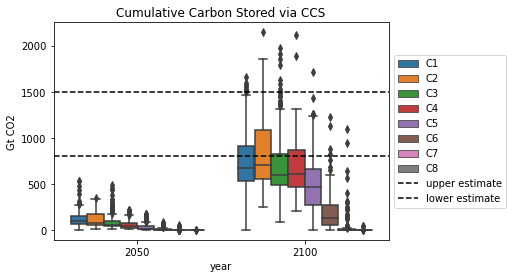

In [10]:
ax = (
    pdf
    .filter(variable='Cumulative CCS', year=[2050, 2100], region='World')
    .convert_unit('Mt CO2/yr', 'Gt CO2', factor=1e-3)
    .plot.box(x="year", by="Category", legend=True)
)
ax.axhline(1500, c='k', ls='--', label='upper estimate')
ax.axhline(800, c='k', ls='--', label='lower estimate')
ax.legend(**pyam.plotting.OUTSIDE_LEGEND['right'])
ax.set_title('Cumulative Carbon Stored via CCS')

C:\Users\gidden\AppData\Local\Temp\ipykernel_16224\716059494.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  boxplot = pdata.plot.box(column=['Cumulative CCS until NZ CO2 in 2100', 'Cumulative CCS in 2100'], by="Category", legend=True, ax=ax)
C:\Users\gidden\AppData\Local\Temp\ipykernel_16224\716059494.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  boxplot[i].axhline(1.5e6, c='k', ls='--', label='upper estimate')
C:\Users\gidden\AppData\Local\Temp\ipykernel_16224\716059494.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  boxplot[i].axhline(0.8e6, c='k'

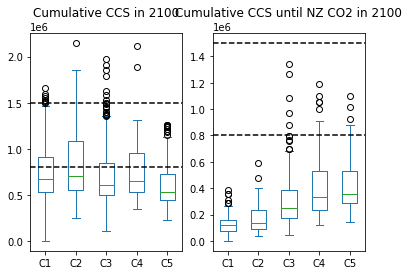

In [11]:
# only scnearios which reach net-zero CO2
fig, ax = plt.subplots()
pdata = pdf.meta[['Cumulative CCS until NZ CO2 in 2100', 'Cumulative CCS in 2100', 'Category', 'Year of netzero CO2 emissions (Harm-Infilled) Table SPM2']]
pdata = pdata[pdata['Year of netzero CO2 emissions (Harm-Infilled) Table SPM2'] < 2101]
boxplot = pdata.plot.box(column=['Cumulative CCS until NZ CO2 in 2100', 'Cumulative CCS in 2100'], by="Category", legend=True, ax=ax)
for i in [0, 1]:
    boxplot[i].axhline(1.5e6, c='k', ls='--', label='upper estimate')
    boxplot[i].axhline(0.8e6, c='k', ls='--', label='lower estimate')

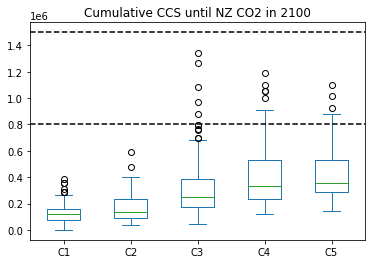

In [12]:
# only scnearios which reach net-zero CO2
fig, ax = plt.subplots()
pdata = pdf.meta[['Cumulative CCS until NZ CO2 in 2100', 'Category', 'Year of netzero CO2 emissions (Harm-Infilled) Table SPM2']]
pdata = pdata[pdata['Year of netzero CO2 emissions (Harm-Infilled) Table SPM2'] < 2101]
boxplot = pdata.plot.box(column=['Cumulative CCS until NZ CO2 in 2100'], by="Category", legend=True, ax=ax)
ax.axhline(1.5e6, c='k', ls='--', label='upper estimate')
ax.axhline(0.8e6, c='k', ls='--', label='lower estimate')

In [54]:
nz = df.meta['Year of netzero CO2 emissions (Harm-Infilled) Table SPM2']
set_meta_at_nz(pdf, nz_co2, name='Carbon Sequestration|CCS at NZ CO2', variable='Carbon Sequestration|CCS', region='World')
set_meta_at_nz(pdf, nz_co2, name='Cumulative Carbon Sequestration|CCS at NZ CO2', variable='Cumulative CCS', region='World')



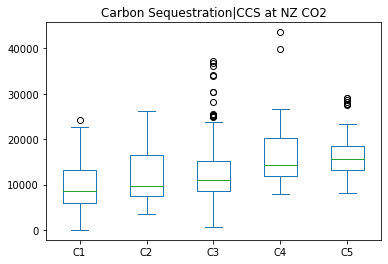

In [14]:
# only scnearios which reach net-zero CO2
fig, ax = plt.subplots()
pdata = pdf.meta[['Carbon Sequestration|CCS at NZ CO2', 'Category', 'Year of netzero CO2 emissions (Harm-Infilled) Table SPM2']]
pdata = pdata[pdata['Year of netzero CO2 emissions (Harm-Infilled) Table SPM2'] < 2101]
boxplot = pdata.plot.box(column=['Carbon Sequestration|CCS at NZ CO2'], by="Category", legend=True, ax=ax)

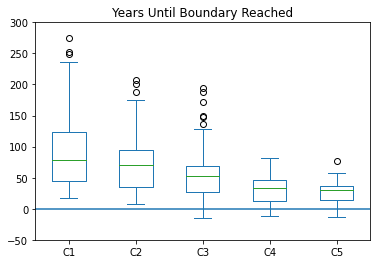

In [15]:
# how many years are left until breach
lim = 0.8e6

fig, ax = plt.subplots()
pdata = pdf.meta[['Cumulative CCS until NZ CO2 in 2100', 'Carbon Sequestration|CCS at NZ CO2', 'Category', 'Year of netzero CO2 emissions (Harm-Infilled) Table SPM2']]
pdata = pdata[pdata['Year of netzero CO2 emissions (Harm-Infilled) Table SPM2'] < 2101]
pdata['Years Until Boundary Reached'] = (lim - pdata['Cumulative CCS until NZ CO2 in 2100']) / pdata['Carbon Sequestration|CCS at NZ CO2']
boxplot = pdata.plot.box(column=['Years Until Boundary Reached'], by="Category", legend=True, ax=ax)
ax.set_ylim(-50, 300)
ax.axhline(0)

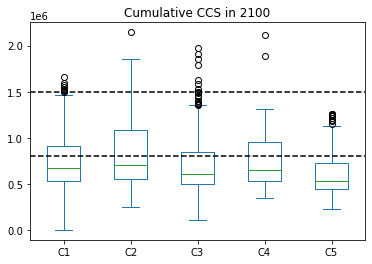

In [16]:
# only scnearios which reach net-zero CO2
fig, ax = plt.subplots()
pdata = pdf.meta[['Cumulative CCS in 2100', 'Category', 'Year of netzero CO2 emissions (Harm-Infilled) Table SPM2']]
pdata = pdata[pdata['Year of netzero CO2 emissions (Harm-Infilled) Table SPM2'] < 2101]
boxplot = pdata.plot.box(column=['Cumulative CCS in 2100'], by="Category", legend=True, ax=ax)
ax.axhline(1.5e6, c='k', ls='--', label='upper estimate')
ax.axhline(0.8e6, c='k', ls='--', label='lower estimate')

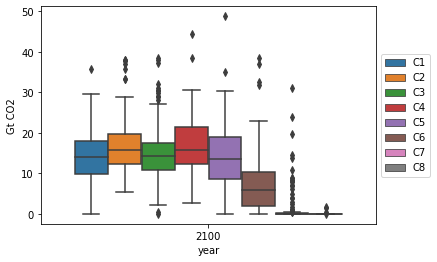

In [17]:
ax = (
    pdf
    .filter(variable='Carbon Sequestration|CCS', year=[2100], region='World')
    .convert_unit('Mt CO2/yr', 'Gt CO2', factor=1e-3)
    .plot.box(x="year", by="Category", legend=True)
)
ax.legend(**pyam.plotting.OUTSIDE_LEGEND['right'])

C:\Users\gidden\AppData\Local\Temp\ipykernel_16224\1303467573.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  boxplot = pdata.plot.box(column=['Cumulative CCS until NZ CO2 in 2100', 'Cumulative CCS in 2100'], by="Category", legend=True, ax=ax)
C:\Users\gidden\AppData\Local\Temp\ipykernel_16224\1303467573.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  boxplot[i].axhline(1.5e6 / lim, c='k', ls='--', label='upper estimate')
C:\Users\gidden\AppData\Local\Temp\ipykernel_16224\1303467573.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  boxplot[i].axhline(0

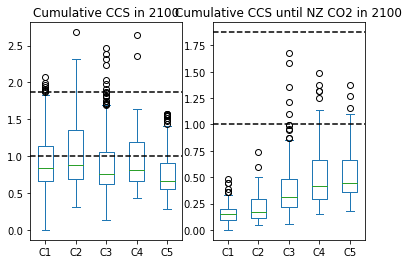

In [18]:
# only scnearios which reach net-zero CO2
fig, ax = plt.subplots()
pdata = pdf.meta[['Cumulative CCS until NZ CO2 in 2100', 'Cumulative CCS in 2100', 'Category', 'Year of netzero CO2 emissions (Harm-Infilled) Table SPM2']].copy()
pdata = pdata[pdata['Year of netzero CO2 emissions (Harm-Infilled) Table SPM2'] < 2101]
lim = 0.8e6
pdata['Cumulative CCS until NZ CO2 in 2100'] /= lim
pdata['Cumulative CCS in 2100'] /= lim
boxplot = pdata.plot.box(column=['Cumulative CCS until NZ CO2 in 2100', 'Cumulative CCS in 2100'], by="Category", legend=True, ax=ax)
for i in [0, 1]:
    boxplot[i].axhline(1.5e6 / lim, c='k', ls='--', label='upper estimate')
    boxplot[i].axhline(0.8e6 / lim, c='k', ls='--', label='lower estimate')

[INFO] 14:51:42 - pyam.plotting: >=13 labels, not applying legend
INFO:pyam.plotting:>=13 labels, not applying legend


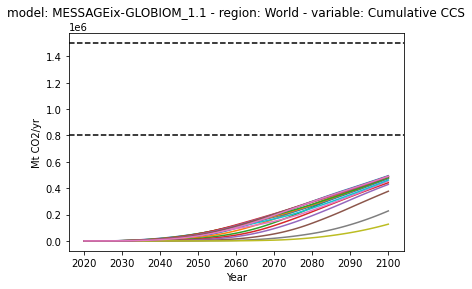

In [19]:
ax = pdf.filter(model='*MESSAGE*', scenario='EN_NPi*_*0f', variable='Cumulative CCS').plot.line()
ax.axhline(1.5e6, c='k', ls='--', label='upper estimate')
ax.axhline(0.8e6, c='k', ls='--', label='lower estimate')

# Apply labels to scenarios

In [81]:
validator = Validation(
    db=pdf.filter(**{'Year of netzero CO2 emissions (Harm-Infilled) Table SPM2': 2101}, keep=False).filter(Category='C*'), # only look at scenarios reaching nz co2
    definitions_path='../definitions/filters.yml',
)

validator.create_validation_columns(
    generate_summary=True
)

validator.summary

INFO:utils:Creating validation column for cstorage_low using defined proxy Cumulative CCS
INFO:utils:Creating validation column for cstorage_mid using defined proxy Cumulative CCS
INFO:utils:Creating validation column for cstorage_high using defined proxy Cumulative CCS
INFO:utils:Creating validation column for cstorage_max using defined proxy Cumulative CCS


validation_cstorage_low  validation_cstorage_mid  validation_cstorage_high  validation_cstorage_max
True                     True                     True                      True                       737
Name: count, dtype: int64

In [82]:
len(pdf.index), len(validator.db.index)

(1196, 737)

In [75]:
filters = Filters(
    db=validator.db.filter(year=range(2020, 2105,5)),
    definitions_path='../definitions/filters.yml'
)

filters.apply_filters()
filters.apply_categories()

INFO:utils:Preparing filter sets for cstorage_low
[INFO] 15:31:57 - pyam.validation: 247 of 256315 data points do not satisfy the criteria
INFO:pyam.validation:247 of 256315 data points do not satisfy the criteria
INFO:utils:Preparing filter sets for cstorage_mid
[INFO] 15:31:57 - pyam.validation: 645 of 256315 data points do not satisfy the criteria
INFO:pyam.validation:645 of 256315 data points do not satisfy the criteria
INFO:utils:Preparing filter sets for cstorage_high
[INFO] 15:31:57 - pyam.validation: 605 of 256315 data points do not satisfy the criteria
INFO:pyam.validation:605 of 256315 data points do not satisfy the criteria
INFO:utils:Preparing filter sets for cstorage_max
[INFO] 15:31:57 - pyam.validation: 714 of 256315 data points do not satisfy the criteria
INFO:pyam.validation:714 of 256315 data points do not satisfy the criteria
INFO:utils:Preparing categorization for cstorage_low
[INFO] 15:31:57 - pyam.validation: 247 of 256315 data points do not satisfy the criteria
I

<Axes: xlabel='Cumulative CCS', ylabel='Cumulative Fossil PE'>

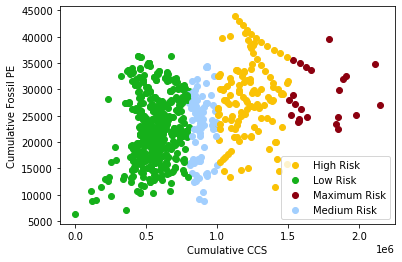

In [76]:
filters.db.filter(year=2100).plot.scatter('Cumulative CCS', 'Cumulative Fossil PE', color='Carbon Storage')

<Axes: xlabel='Cumulative CCS until NZ CO2', ylabel='Cumulative Fossil PE until NZ CO2'>

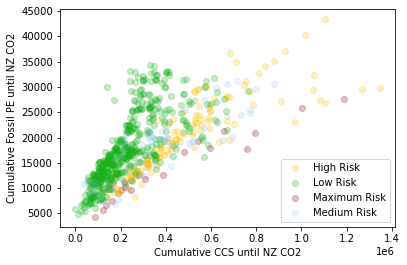

In [77]:
filters.db.filter(year=2100).plot.scatter('Cumulative CCS until NZ CO2', 'Cumulative Fossil PE until NZ CO2', color='Carbon Storage', alpha=0.25)

<Axes: xlabel='Cumulative CCS', ylabel='Cumulative Fossil PE'>

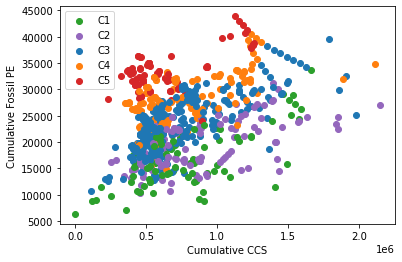

In [78]:
filters.db.filter(year=2100).plot.scatter('Cumulative CCS', 'Cumulative Fossil PE', color='Category')

<Axes: xlabel='Cumulative Fossil PE in 2100', ylabel='Median peak warming (MAGICCv7.5.3)'>

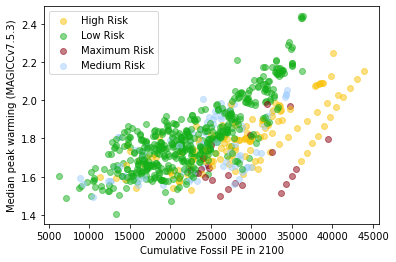

In [79]:
filters.db.plot.scatter(
    'Cumulative Fossil PE in 2100', 'Median peak warming (MAGICCv7.5.3)', 
    color='Carbon Storage', alpha=0.5,
    )

<Axes: xlabel='Cumulative Fossil PE in 2100', ylabel='Median peak warming (MAGICCv7.5.3)'>

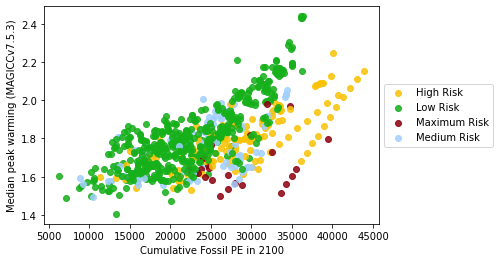

In [80]:
filters.db.plot.scatter(
    'Cumulative Fossil PE in 2100', 'Median peak warming (MAGICCv7.5.3)', 
    color='Carbon Storage', alpha=0.85,
    legend={'loc': 'outside right'}
    )

In [63]:
filters.db.set_meta(
    filters.db['Median peak warming (MAGICCv7.5.3)'] - filters.db['Median warming in 2100 (MAGICCv7.5.3)'],
    name='Median warming drawdown in 2100 (MAGICCv7.5.3)',
)


<Axes: xlabel='Cumulative CCS in 2100', ylabel='Median warming drawdown in 2100 (MAGICCv7.5.3)'>

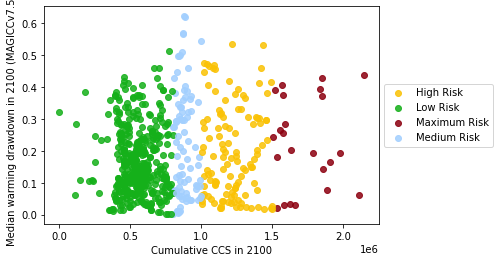

In [65]:
filters.db.filter(Category=['C1', 'C2', 'C3', 'C4']).plot.scatter(
    'Cumulative CCS in 2100', 'Median warming drawdown in 2100 (MAGICCv7.5.3)', 
    color='Carbon Storage', alpha=0.85,
    legend={'loc': 'outside right'}
    )

In [68]:
filters.db.meta['Cumulative CCS Increase after NZ CO2 (factor)'] = filters.db.meta['Cumulative CCS in 2100'] / filters.db.meta['Cumulative Carbon Sequestration|CCS at NZ CO2']
filters.db.meta['Cumulative CCS Increase after NZ CO2'] = filters.db.meta['Cumulative CCS in 2100'] - filters.db.meta['Cumulative Carbon Sequestration|CCS at NZ CO2']

<Axes: xlabel='Cumulative CCS Increase after NZ CO2', ylabel='Median warming drawdown in 2100 (MAGICCv7.5.3)'>

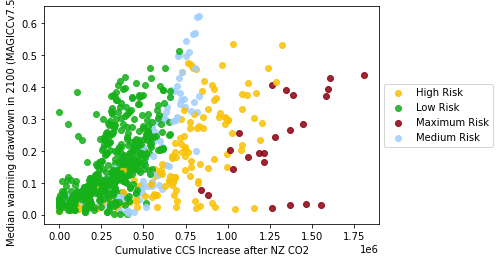

In [72]:
filters.db.plot.scatter(
    'Cumulative CCS Increase after NZ CO2', 'Median warming drawdown in 2100 (MAGICCv7.5.3)', 
    color='Carbon Storage', alpha=0.85,
    legend={'loc': 'outside right'}
    )

<Axes: xlabel='Cumulative Fossil PE in 2100', ylabel='Median warming drawdown in 2100 (MAGICCv7.5.3)'>

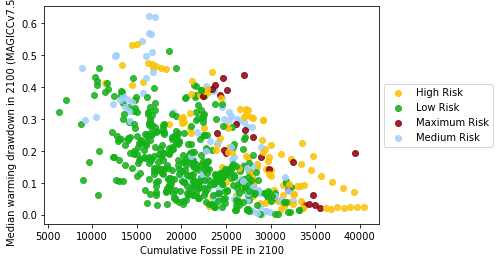

In [32]:
filters.db.filter(Category=['C1', 'C2', 'C3', 'C4']).plot.scatter(
    'Cumulative Fossil PE in 2100', 'Median warming drawdown in 2100 (MAGICCv7.5.3)', 
    color='Carbon Storage', alpha=0.85,
    legend={'loc': 'outside right'}
    )

<Axes: xlabel='Cumulative Renewables PE in 2100', ylabel='Median warming drawdown in 2100 (MAGICCv7.5.3)'>

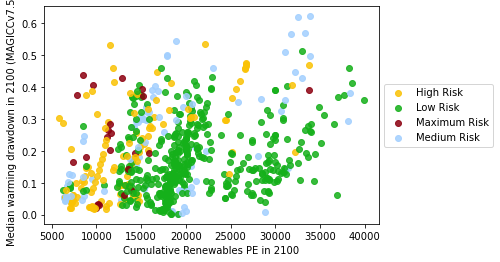

In [33]:
filters.db.filter(Category=['C1', 'C2', 'C3', 'C4']).plot.scatter(
    'Cumulative Renewables PE in 2100', 'Median warming drawdown in 2100 (MAGICCv7.5.3)', 
    color='Carbon Storage', alpha=0.85,
    legend={'loc': 'outside right'}
    )


<Axes: xlabel='Cumulative Fossil CCS in 2100', ylabel='Median warming drawdown in 2100 (MAGICCv7.5.3)'>

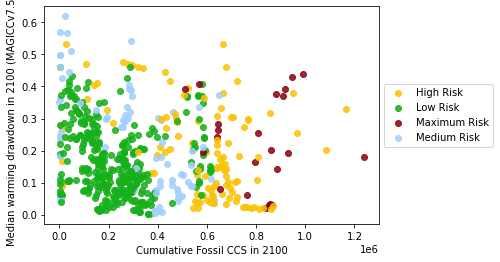

In [34]:
filters.db.filter(Category=['C1', 'C2', 'C3', 'C4']).plot.scatter(
    'Cumulative Fossil CCS in 2100', 'Median warming drawdown in 2100 (MAGICCv7.5.3)', 
    color='Carbon Storage', alpha=0.85,
    legend={'loc': 'outside right'}
    )
